<a href="https://colab.research.google.com/github/atick-faisal/Sign-Language-Recognition/blob/main/core/colab/ProjectionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !gdown "1zqe3jjWXzzp_VWxBQzU_vTnFZLFKhGZd"
# !jar -xvf "lmc_dataset_stack_cnn.zip"

In [2]:
import os
import joblib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models


# Configuration

In [3]:
class config(object):
    INFERENCE_TIME = 3.0  # ... Segment duration
    HOLD_TIME = 2.0  # ... Time before next prediction session
    SEGMENT_LEN = 150
    IMG_LEN = 160  # 1/9 of the 224x224 image
    N_CHANNELS = 3
    LEARNING_RATE = 0.0003
    BATCH_SIZE = 32
    N_EPOCHS = 300
    PATIENCE = 30
    PROJECTION_LANDMARKS = ["rp", "rf0", "rf1"]
    INFERENCE_FEATURES = [
        "rpx",
        "rpy",
        "rpz",
        "rf0x",
        "rf0y",
        "rf0z",
        "rf1x",
        "rf1y",
        "rf1z"
    ]
    MODEL_PREDICTION = "dev.atick.slr.model.prediction"
    FRAME_EVENT = "dev.atick.slr.frame"
    GESTURES = ["Good", "Bad", "Fine", "Hello", "Yes", "Deaf", "Me",
                "No", "Please", "Sorry", "Thank You", "You", "Hungry", "Goodbye"]
    FEATURE_NAMES = [
        "time",
        "rpx",
        "rpy",
        "rpz",
        "lpx",
        "lpy",
        "lpz",
        "rf0x",
        "rf0y",
        "rf0z",
        "rf1x",
        "rf1y",
        "rf1z",
        "rf2x",
        "rf2y",
        "rf2z",
        "rf3x",
        "rf3y",
        "rf3z",
        "rf4x",
        "rf4y",
        "rf4z",
        "lf0x",
        "lf0y",
        "lf0z",
        "lf1x",
        "lf1y",
        "lf1z",
        "lf2x",
        "lf2y",
        "lf2z",
        "lf3x",
        "lf3y",
        "lf3z",
        "lf4x",
        "lf4y",
        "lf4z",
    ]


# Load Dataset

In [4]:
X_train = joblib.load("X_train_stack_11.joblib")
y_train = joblib.load("y_train_stcak_11.joblib")
X_test = joblib.load("X_test_stack_11.joblib")
y_test = joblib.load("y_test_stack_11.joblib")

print(X_train[0].shape)
print(X_test[0].shape)
print(X_train[-1].shape)
print(X_test[-1].shape)
print(y_train.shape)
print(y_test.shape)

(4675, 150, 1)
(224, 150, 1)
(4675, 160, 160, 3)
(224, 160, 160, 3)
(4675,)
(224,)


# Model Construction

In [5]:
class ProjectionNet():
    def __init__(
        self,
        n_classes: int,
        base_model: tf.keras.Model,
        feature_vector_shape: tuple = (150, 1),
        projection_img_shape: tuple = (160, 160, 3),
        n_feature_vectors: int = 6,
        n_projections: int = 3
    ):
        self.projection_img_shape = projection_img_shape
        self.feature_vector_shape = feature_vector_shape
        self.n_feature_vectors = n_feature_vectors
        self.n_projections = n_projections
        self.base_model = base_model
        self.base_model.trainable = False

        self.dropout = layers.Dropout(0.5)

        self.mlp1 = layers.Dense(
            units=128,
            activation="relu"
        )

        self.mlp2 = layers.Dense(
            units=n_classes,
            activation="softmax"
        )

    def conv_block_1d(self):
        inputs = layers.Input(shape=self.feature_vector_shape)
        x = layers.BatchNormalization()(inputs)
        x = layers.Conv1D(16, 3, activation="selu")(x)
        x = layers.Conv1D(16, 3, activation="selu")(x)
        x = layers.MaxPool1D(2)(x)
        x = layers.Conv1D(32, 3, activation="selu")(x)
        x = layers.Conv1D(32, 3, activation="selu")(x)
        x = layers.MaxPool1D(2)(x)
        x = layers.Flatten()(x)
        output = layers.Dense(32)(x)

        return inputs, output

    def conv_block_2d(self):
        preprocess = layers.experimental.preprocessing.Rescaling(
            scale=1.0/127.5,
            offset=-1
        )
        inputs = layers.Input(shape=self.projection_img_shape)
        x = preprocess(inputs)
        x = self.base_model(x, training=False)
        output = layers.GlobalAveragePooling2D()(x)

        return inputs, output

    def model(self):

        inputs = []
        features = []

        for _ in range(self.n_feature_vectors):
            input_1d, features_1d = self.conv_block_1d()
            inputs.append(input_1d)
            features.append(features_1d)

        for _ in range(self.n_projections):
            input_2d, features_2d = self.conv_block_2d()
            inputs.append(input_2d)
            features.append(features_2d)

        x = layers.concatenate(features, axis=-1)
        x = self.dropout(x)
        x = self.mlp1(x)
        x = self.dropout(x)
        output = self.mlp2(x)

        return models.Model(inputs, output)

# Training

In [6]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(config.IMG_LEN, config.IMG_LEN, config.N_CHANNELS),
    include_top=False,
    weights="imagenet"
)

model = ProjectionNet(
    n_classes=len(config.GESTURES),
    base_model=base_model
).model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=config.PATIENCE,
        restore_best_weights=True
    )
]

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=config.BATCH_SIZE,
    epochs=config.N_EPOCHS,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/300
147/147 [==============================] - 33s 102ms/step - loss: 1.6854 - accuracy: 0.4738 - val_loss: 0.7044 - val_accuracy: 0.8884
Epoch 2/300
147/147 [==============================] - 12s 83ms/step - loss: 0.6214 - accuracy: 0.8058 - val_loss: 0.3675 - val_accuracy: 0.9018
Epoch 3/300
147/147 [==============================] - 12s 82ms/step - loss: 0.4562 - accuracy: 0.8535 - val_loss: 0.2980 - val_accuracy: 0.9286
Epoch 4/300
147/147 [==============================] - 12s 82ms/step - loss: 0.3611 - accuracy: 0.8811 - val_loss: 0.2811 - val_accuracy: 0.9420
Epoch 5/300
147/147 [==============================] - 12s 81ms/step - loss: 0.2825 - accuracy: 0.9082 - val_loss: 0.2396 - val_accuracy: 0.9375
Epoch 6/300
147/147 [==============================] - 12s 82ms/step - loss: 0.2627 - accuracy: 0.9108 - val_loss: 0.2460 - val_accuracy: 0.9509
Epoch 7/300
147/147 [==============================] - 12s 83ms/step - loss: 0.2451 - accuracy: 0.9149 - val_loss: 0.2196 - val_a

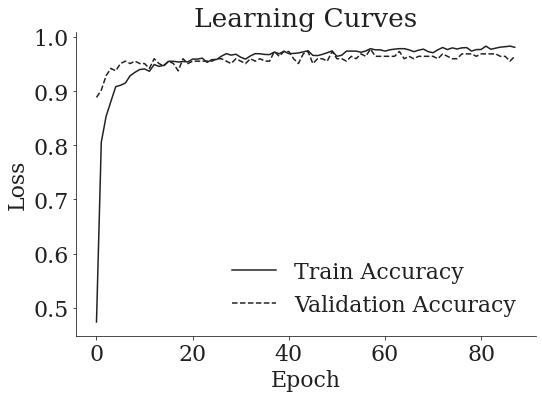

In [7]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    # "text.usetex": True,
    "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "font.size": 22,
    "text.color": "#212121",
    "axes.edgecolor": "#212121",
    "xtick.color": "#212121",
    "ytick.color": "#212121",
    "axes.labelcolor": "#212121",
    'legend.frameon': False,
})

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax.plot(history.history["accuracy"], "-", color="#212121", label="Train Accuracy")
ax.plot(history.history["val_accuracy"], "--",
        color="#212121", label="Validation Accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Learning Curves")
plt.legend()
plt.tight_layout()
plt.savefig("lc_acc.svg")
plt.show()


# Evaluation

In [8]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 1s 73ms/step - loss: 0.3243 - accuracy: 0.9777


[0.3243010938167572, 0.9776785969734192]

In [9]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      1.00      1.00        21
           2       0.85      1.00      0.92        17
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        15
           5       0.94      1.00      0.97        15
           6       1.00      0.94      0.97        17
           7       1.00      1.00      1.00        10
           8       1.00      0.86      0.93        22
           9       1.00      1.00      1.00        20
          10       1.00      0.93      0.97        15
          11       1.00      1.00      1.00        13
          12       1.00      1.00      1.00        17
          13       1.00      1.00      1.00        18

    accuracy                           0.98       224
   macro avg       0.98      0.98      0.98       224
weighted avg       0.98      0.98      0.98       224



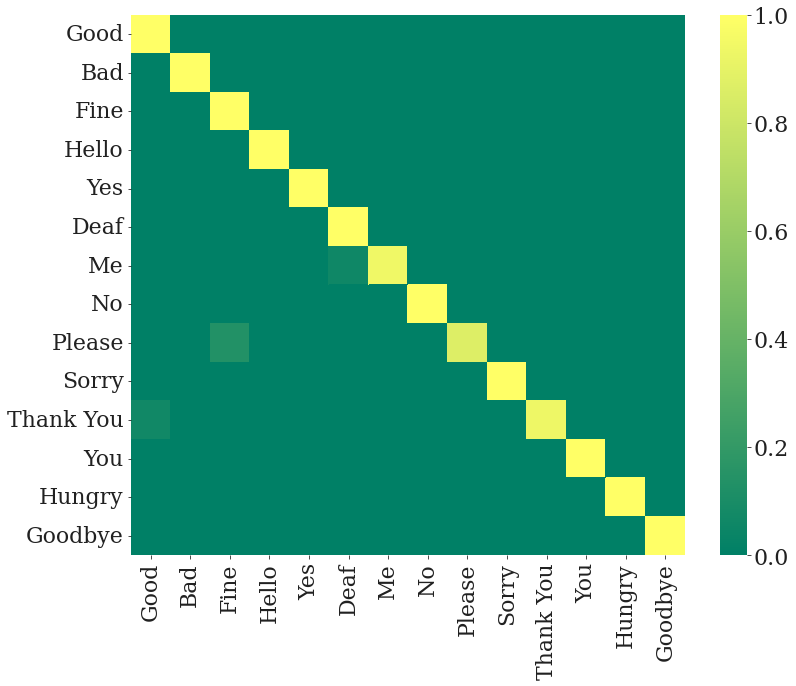

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred, normalize="true")
sns.heatmap(cm, cmap="summer")
plt.xticks(np.arange(len(config.GESTURES)) + 0.5, config.GESTURES, rotation=90)
plt.yticks(np.arange(len(config.GESTURES)) + 0.5, config.GESTURES, rotation=0)
plt.tight_layout()
plt.savefig("cm.svg")

In [11]:
model.save("stack_cnn.h5", save_format="h5")